# Importing libraries and Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import matplotlib.dates as mdates
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
#from pycaret.time_series import TSForecastingExperiment

In [3]:
dengue_df=pd.read_csv('assets/dengue_df.csv', index_col=0)
dengue_df.index=pd.to_datetime(dengue_df.index)
print(dengue_df.info())
dengue_df.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2014-01-05 to 2023-01-01
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No. case          470 non-null    float64
 1   temp              470 non-null    float64
 2   humidity          470 non-null    float64
 3   precip            470 non-null    float64
 4   precipcover       470 non-null    float64
 5   windspeed         470 non-null    float64
 6   winddir           470 non-null    float64
 7   sealevelpressure  470 non-null    float64
 8   solarenergy       470 non-null    float64
dtypes: float64(9)
memory usage: 36.7 KB
None


No. case       temp   humidity    precip  precipcover  windspeed  \
datetime                                                                       
2014-01-05     436.0  26.900000  85.700000  2.987800     5.834000  19.660000   
2014-01-12     479.0  26.785714  85.800000  7.105571     5.954286  19.371429   
2014-01-19     401.0  26.528571  76.857143  0.000000     0.000000  26.371429   
2014-01-26     336.0  25.928571  74.700000  0.000000     0.000000  25.728571   
2014-02-02     234.0  26.257143  72.942857  0.000000     0.000000  21.657143   

              winddir  sealevelpressure  solarenergy  
datetime                                              
2014-01-05  88.780000       1010.420000    13.480000  
2014-01-12  68.128571       1010.057143    10.700000  
2014-01-19  27.814286       1012.585714    20.485714  
2014-01-26  27.900000       1012.342857    19.642857  
2014-02-02  32.442857       1011.485714    23.585714

# General Approach and Objective

- Objective:
    - Minimum MAPE of 0.269 over a predicted period of 12 weeks
- General Approach:
    - Use of all periods despite abnormally high or low cases since the ARIMA models take into account of shocks through the moving average component and the data are based of weekly which should provides sufficient data for the model to learn on these fluctuations. 
    - Further approaches to include exogeneous factors (i.e weather features) in assisting the model to achieve more accurate predictions.

In [4]:
def plot_forecast_period(y_train, y_test, arima_model, period ,X_test=None):
    
    if X_test is None:
        y_pred = arima_model.predict(n_periods = period)
    else:
        y_pred = arima_model.predict(n_periods = period, X=X_test[:period])

    # Plot data.
    plt.figure(figsize=(30,15))

    plt.plot(y_train, color='blue', label='y_train')
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)
    plt.plot(y_test.index[:period], y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    mape = mean_absolute_percentage_error(y_test[:period], y_pred)
    
    plt.title(label = f'Dengue Case Predictions\n MAPE: {mape:.2f}', fontsize=20) 
    plt.legend(fontsize = 20, loc = 'upper left'); 

# Approach 1: Baseline ARIMA

- All periods from 2014 to 2021 will be use for training and predictions will be compared against 2022 data.

## Train test split

In [5]:
#Train test split for ARIMA modeling
y_train=dengue_df['No. case'].loc['2014':'2021']
y_test=dengue_df['No. case'].loc['2022']

## ACF and PACF

Augmented Dicky-Fuller test on the need to difference the rows to have a stationary model.

In [6]:
#Checking if the need to difference
adf_test = ADFTest(alpha = 0.05)
print(adf_test.should_diff(y_train))

(0.021319462143662718, False)


ACF and PACF will be plotted to understand the order of auto-regression and moving average to be decided for the parameters in the ARIMA model. Despite using AutoARIMA for more efficient modeling process, understanding the optimal parameters reduce likelihood for AutoARIMA to stop fitting parameters prematurely. Additionally, the plots also provides insight on whether seasonality is present.

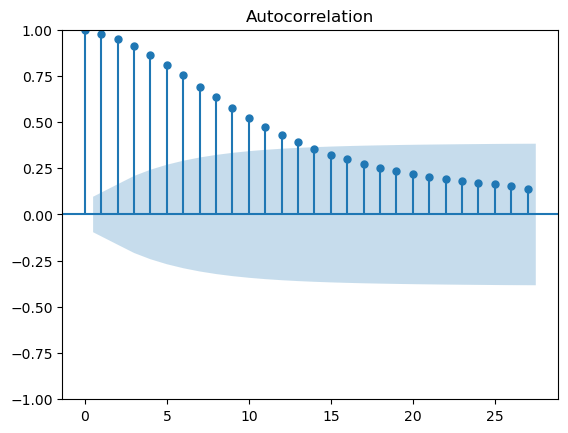

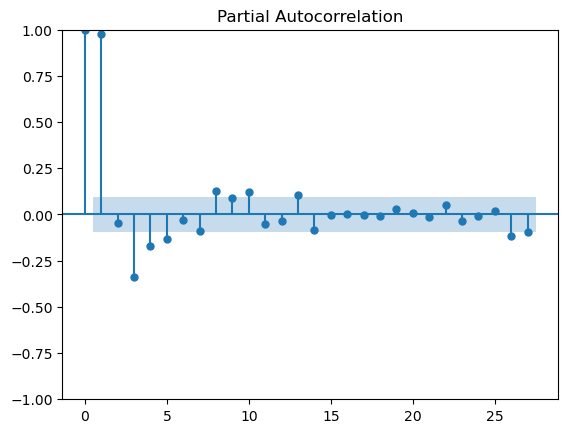

In [8]:
#Plot of ACF and PACF to determine seasonality and optimal degrees of AR and MA
plot_acf(y_train)
plot_pacf(y_train);

- Autocorrelation occurs till the 13 period of lag based on the cut-off of ACF plot which will be implemented in the MA process.
- After the 1st lag in the PACF plot, there is a huge fall in autocorrelation, this suggest that the degree of moving average should be set at 1 since further lags have no significant spikes as compare to this 1st lag.
- No seasonality can be visually detected through the periods of lag.

## Modeling

Use of auto-arima model to fit in best degree of Autoregression (AR), Moving average (MA) and difference (I)

In [20]:
arima_model_base = pm.auto_arima(y_train, start_p=1, max_p=20, 
                           d=None,    
                           start_q=13, max_q=20,
                           trace=True,
                           random_state=1,
                           n_fits=100)

arima_model_base.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,13)(0,0,0)[0] intercept   : AIC=4515.778, Time=3.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5859.787, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4578.669, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5429.258, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6117.201, Time=0.05 sec
 ARIMA(0,0,13)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,0,12)(0,0,0)[0] intercept   : AIC=4514.594, Time=3.18 sec
 ARIMA(0,0,12)(0,0,0)[0] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(1,0,11)(0,0,0)[0] intercept   : AIC=4514.741, Time=2.50 sec
 ARIMA(2,0,12)(0,0,0)[0] intercept   : AIC=4517.643, Time=3.40 sec
 ARIMA(0,0,11)(0,0,0)[0] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(2,0,11)(0,0,0)[0] intercept   : AIC=4516.395, Time=2.31 sec
 ARIMA(2,0,13)(0,0,0)[0] intercept   : AIC=4518.475, Time=3.87 sec
 ARIMA(1,0,12)(0,0,0)[0]             : AIC=4520.090, Time=0.97 sec

Best model:  ARIMA(1,0,12)(0,0,0)[0] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  417
Model:              SARIMAX(1, 0, 12)   Log Likelihood               -2242.297
Date:                Sun, 11 Jun 2023   AIC                           4514.594
Time:                        16:29:23   BIC                           4575.090
Sample:                    01-05-2014   HQIC                          4538.512
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.2498     15.821      1.406      0.160      -8.758      53.258
ar.L1          0.9124      0.043     21.172      0.000       0.828       0.997
ma.L1          0.0107      0.053      0.199      0.842      -0.094       0.115
ma.L2          0.3161      0.050      6.355      0.000       0.219       0.414
ma.L3          0.1845      0.060      3.059      0.002       0.066       0.303
ma.L4          0.2660      0.073      3.619      0.000       0.122       0.410
ma.L5          0.1757      0.065      2.708      0.007       0.049       0.303
ma.L6          0.2558      0.080      3.215      0.001       0.100       0.412
ma.L7          0.0676      0.094      0.718      0.473      -0.117       0.252
ma.L8          0.1001      0.091      1.102      0.270      -0.078       0.278
ma.L9         -0.0509      0.072     -0.706      0.480      -0.192       0.090
ma.L10         0.1463      0.071      2.057      0.040       0.007       0.286
ma.L11        -0.0301      0.073     -0.411      0.681      -0.174       0.114
ma.L12        -0.0921      0.065     -1.422      0.155      -0.219       0.035
sigma2      2711.6836    103.416     26.221      0.000    2508.991    2914.376
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2182.76
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             0.14
Prob(H) (two-sided):                  0.09   Kurtosis:                        14.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluation

#### Diagnositc plot on residuals

- Summary of plots to understand if the time series model performance metric can be trusted by checking if the assumptions are satisfied. 

- Plots included are:
    - [Standardized residuals over time](https://www.statisticshowto.com/what-is-a-standardized-residuals/)
    - [Histogram and density of residuals](https://homepage.divms.uiowa.edu/~luke/classes/STAT4580/histdens.html)
    - [Normal Q-Q](https://data.library.virginia.edu/understanding-q-q-plots/)
    - Correlogram of residuals (i.e ACF)


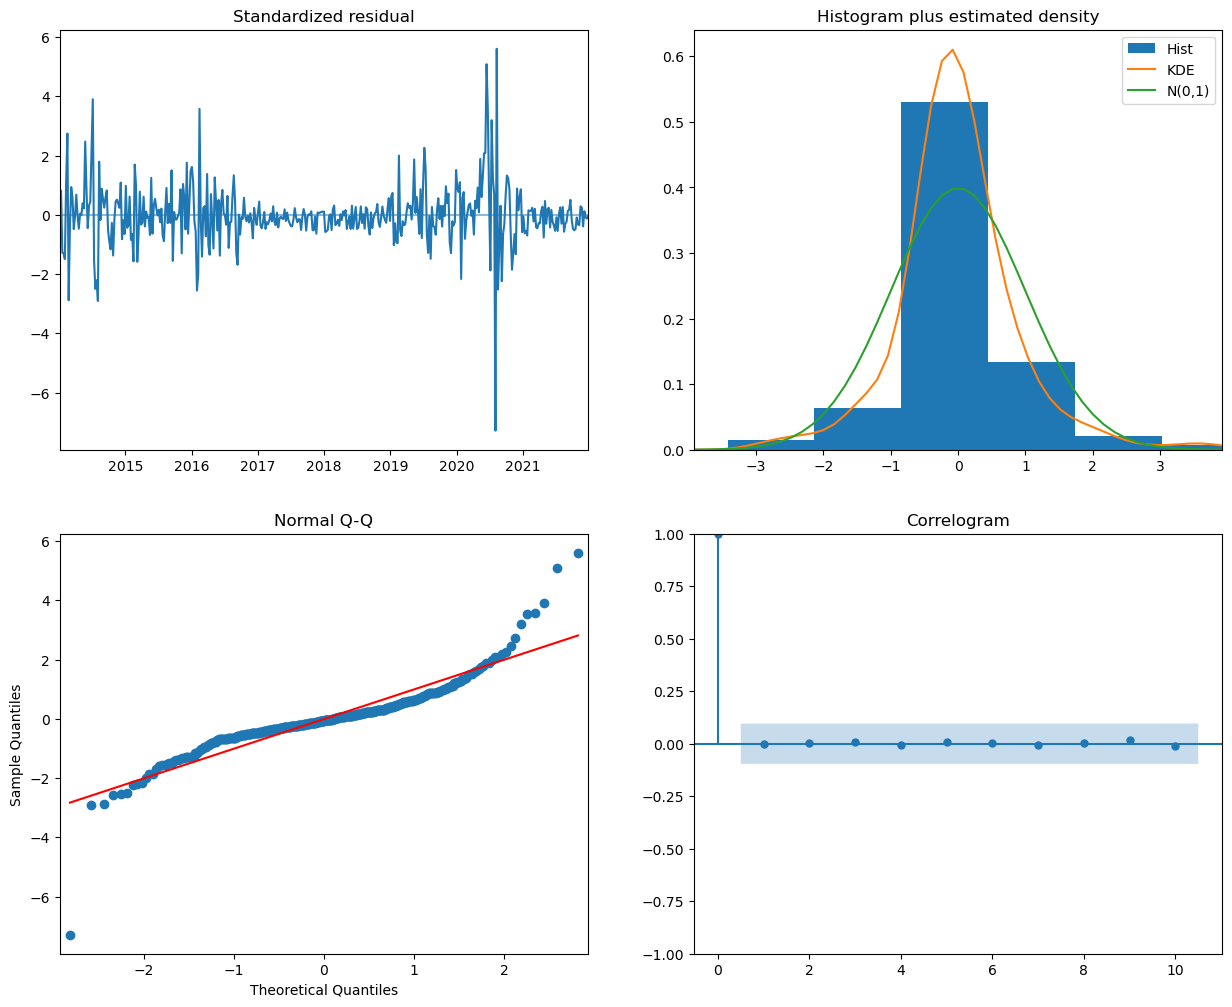

In [21]:
#Checking on the assumption of residuals of the baseline ARIMA model
arima_model_base.plot_diagnostics(figsize=(15,12))
plt.show()

**Conclusion:**
- There are some variance on the residuals of the model predictions, exceptionally during the 2020 period which is due to the abnormal increase during this period.
- The histogram and Q-Q plot illustrates that the residuals are close to being normally distributed.
- All points of the correlation plot of the residuals are within the 95% interval which indicates that the model is able to capture the information in the data.
- Thus this model have satisfied most of the assumptions taken for it to be reliable but due to it being underperforming, other approaches will be explored.

#### Metric performance

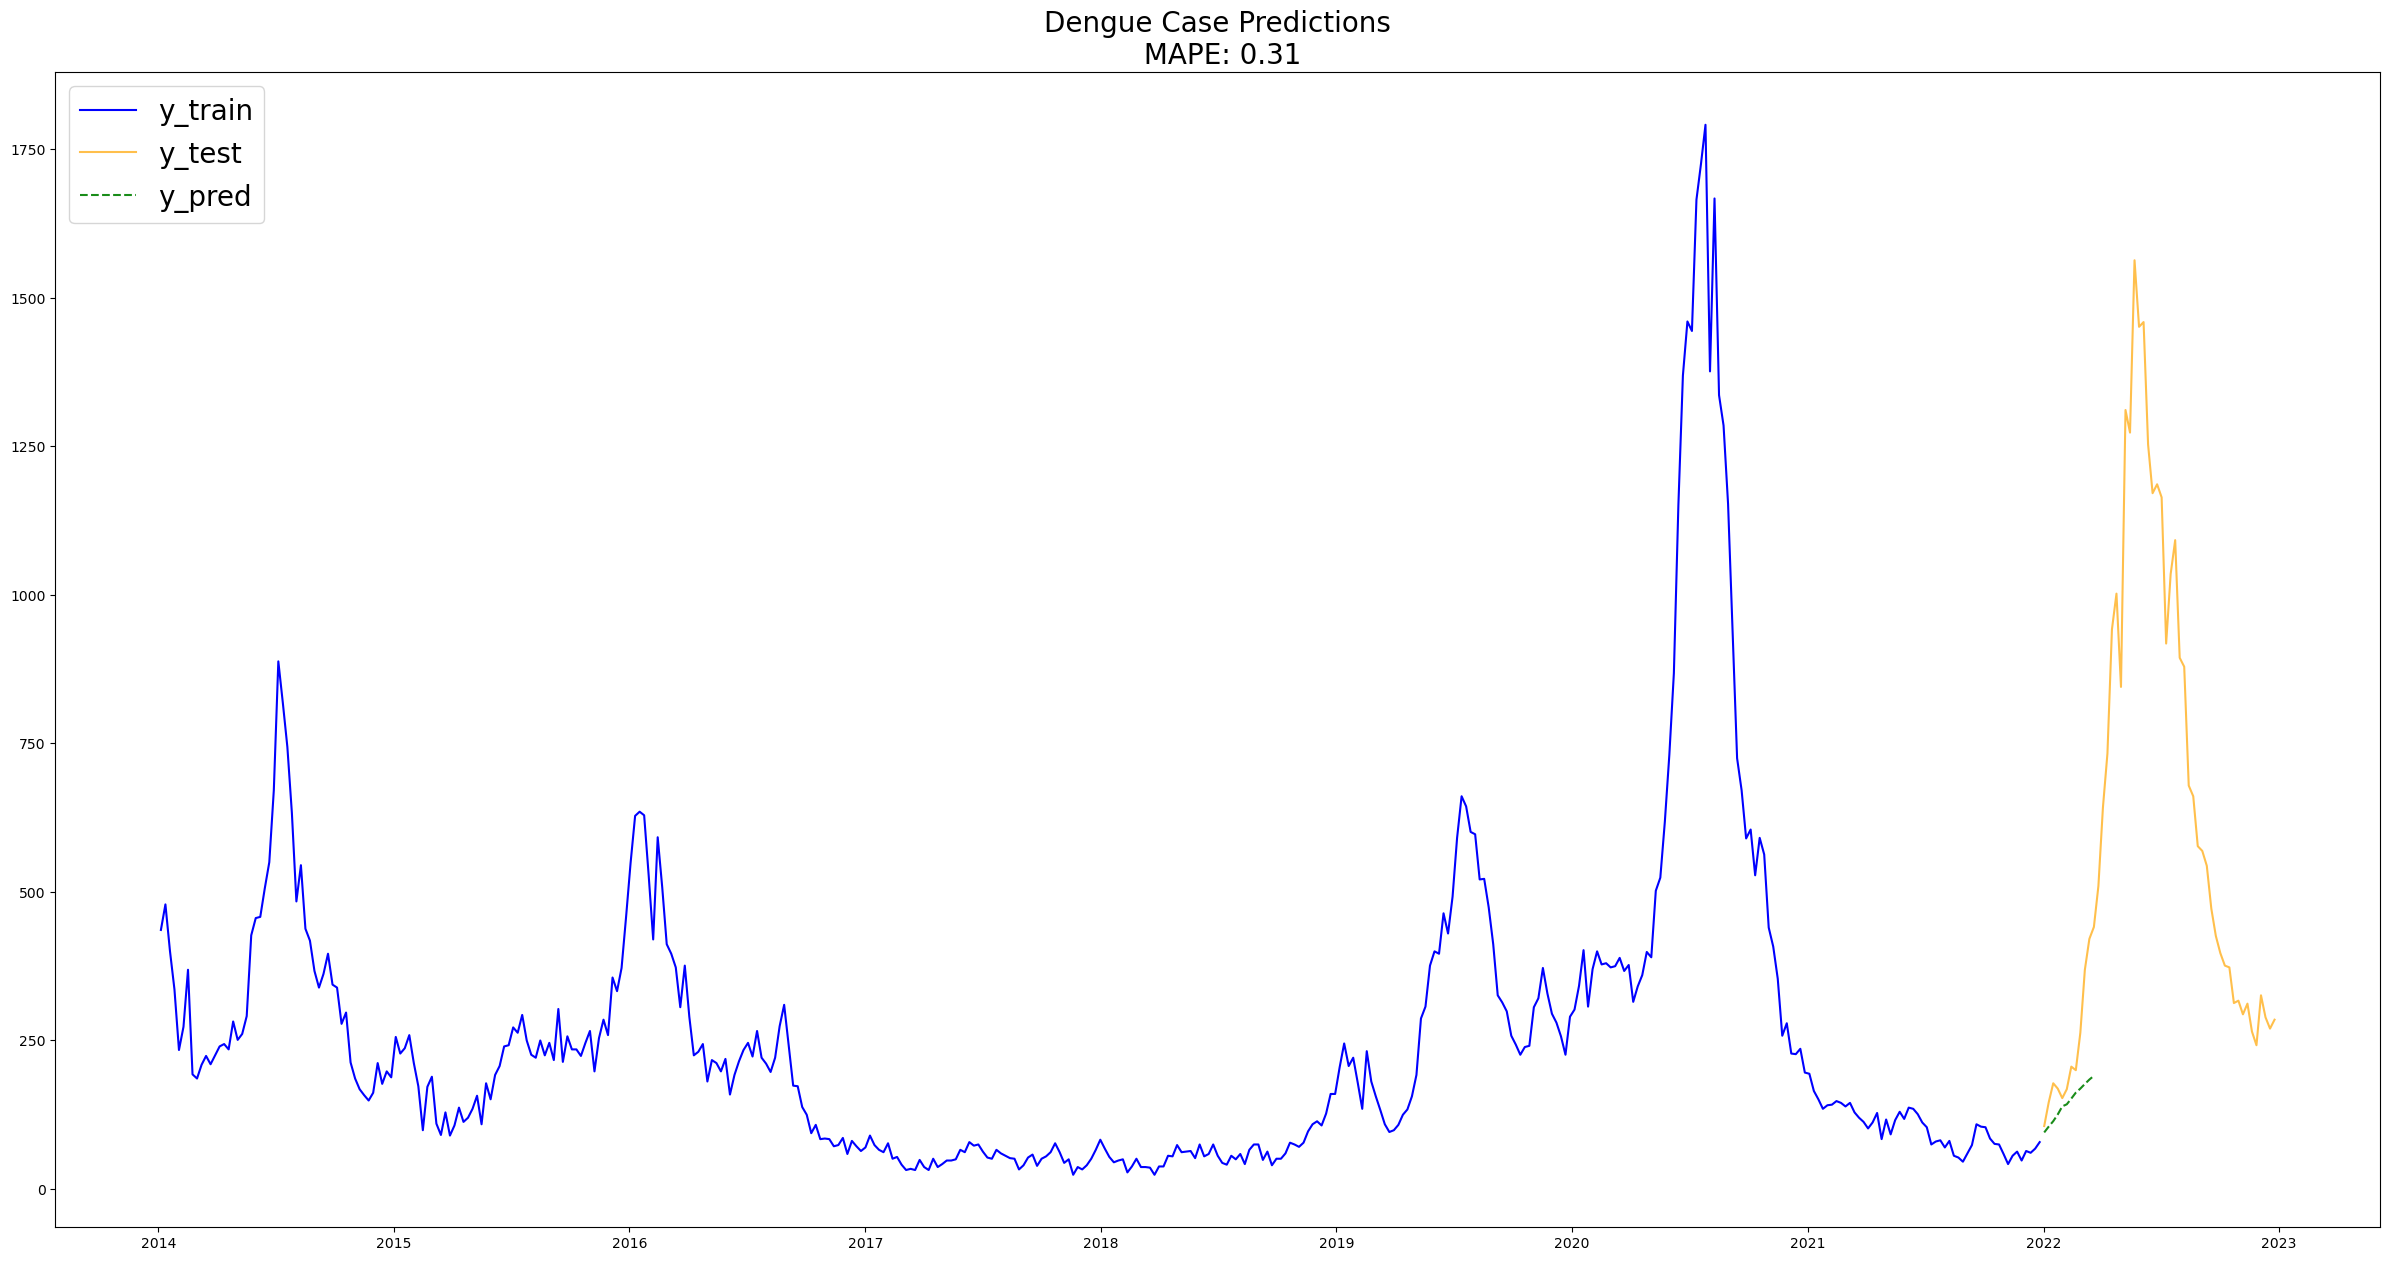

In [22]:
#Plot of forecast with metric
plot_forecast_period(y_train, y_test, arima_model_base,12)

**Conclusion:**
- The metric, MAPE, is 0.31 for the period forecasted of over 12 weeks which is higher than the minimum acceptable range of 0.269.
    - The poor metric could be probably due to the predictions are on period of the start of an abnormal peak.
- Further approach will be conducted with exogeneous factors (i.e weather conditions) taken into account.

# Approach 2: SARIMAX (+ weather features)

- Includes exogeneous factor of weather features using the SARIMAX model
- The exogenous factors will be lag by 2 weeks since the time taken for an Aedes mosquito to hatch from eggs to a breeding adult takes about [10 days](https://www.nea.gov.sg/dengue-zika/prevent-aedes-mosquito-breeding/aedes-mosquito#:~:text=The%20mosquito%20can%20lay%20eggs,such%20as%20water%20and%20food.)

In [15]:
#Train test split exogeneous features with delay of 2 weeks 

#Filter out train and test years of feature
X_train = dengue_df.loc['2014':'2021']
X_test = dengue_df.loc[dengue_df.index.year.isin([2022])]

#Drop NaN values occured after shifting by 2
X_train_shift=X_train.shift(2).dropna()
X_test_shift=X_test.shift(2).dropna()

#Filtering out only exogeneous factors
X_train_SARIMAX=X_train_shift.drop('No. case', axis=1)
X_test_SARIMAX=X_test_shift.drop('No. case', axis=1)

In [16]:
#Train test split dengue cases for ARIMAX modeling
y_train_SARIMAX=dengue_df['No. case'].loc['2014':'2021'][2:]
y_test_SARIMAX=dengue_df['No. case'].loc[dengue_df.index.year.isin([2022])][2:]

## ACF PACF

Augmented Dicky-Fuller test on the need to difference the rows to have a stationary model.

In [17]:
#Checking if the need to difference
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(y_train_SARIMAX)

(0.020757437594504744, False)

Similarly, to understand the optimal starting points of the order of AR and MA as well as presence of seasonality.

/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


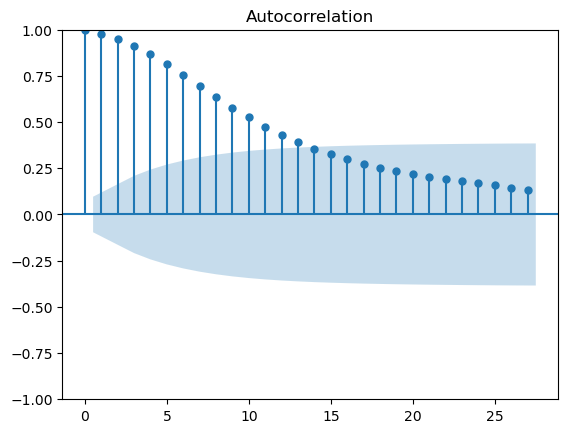

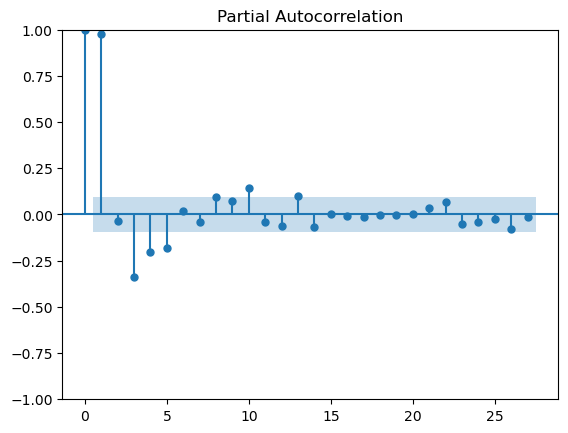

In [18]:
#Plot of ACF and PACF to determine seasonality and optimal degrees of AR and MA
plot_acf(y_train_SARIMAX)
plot_pacf(y_train_SARIMAX);

- Similar conclusion to baseline ARIMA results that no seasonality is detected

## Preprocessing

In [24]:
#Instantiate StandardScaler
SS=StandardScaler()

#StandardScaling the weather features
scaled_train_array=SS.fit_transform(X_train_SARIMAX)
X_train_scaled=pd.DataFrame(scaled_train_array, index=X_train_SARIMAX.index, columns=X_train_SARIMAX.columns)

scaled_test_array=SS.transform(X_test_SARIMAX)
X_test_scaled=pd.DataFrame(scaled_test_array, index=X_test_SARIMAX.index, columns=X_test_SARIMAX.columns)

## Modeling

In [39]:
arima_model_exo = pm.auto_arima(y_train_SARIMAX, X=X_train_scaled, 
                                start_p=1, max_p=50,
                               d=None, D=None,    
                               start_q=12, max_q=50,   
                               seasonal=False,
                               trace=True,
                               random_state=1,
                               n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(1,1,12)(0,0,0)[0] intercept   : AIC=inf, Time=5.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4557.908, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4559.731, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4559.803, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4555.987, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4540.837, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4507.015, Time=1.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4516.618, Time=1.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4508.354, Time=1.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4505.133, Time=1.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4503.802, Time=1.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4525.551, Time=1.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4505.695, Time=1.72 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4521.196, Time=1.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   :

## Evaluation

#### Diagnositc plot on residuals

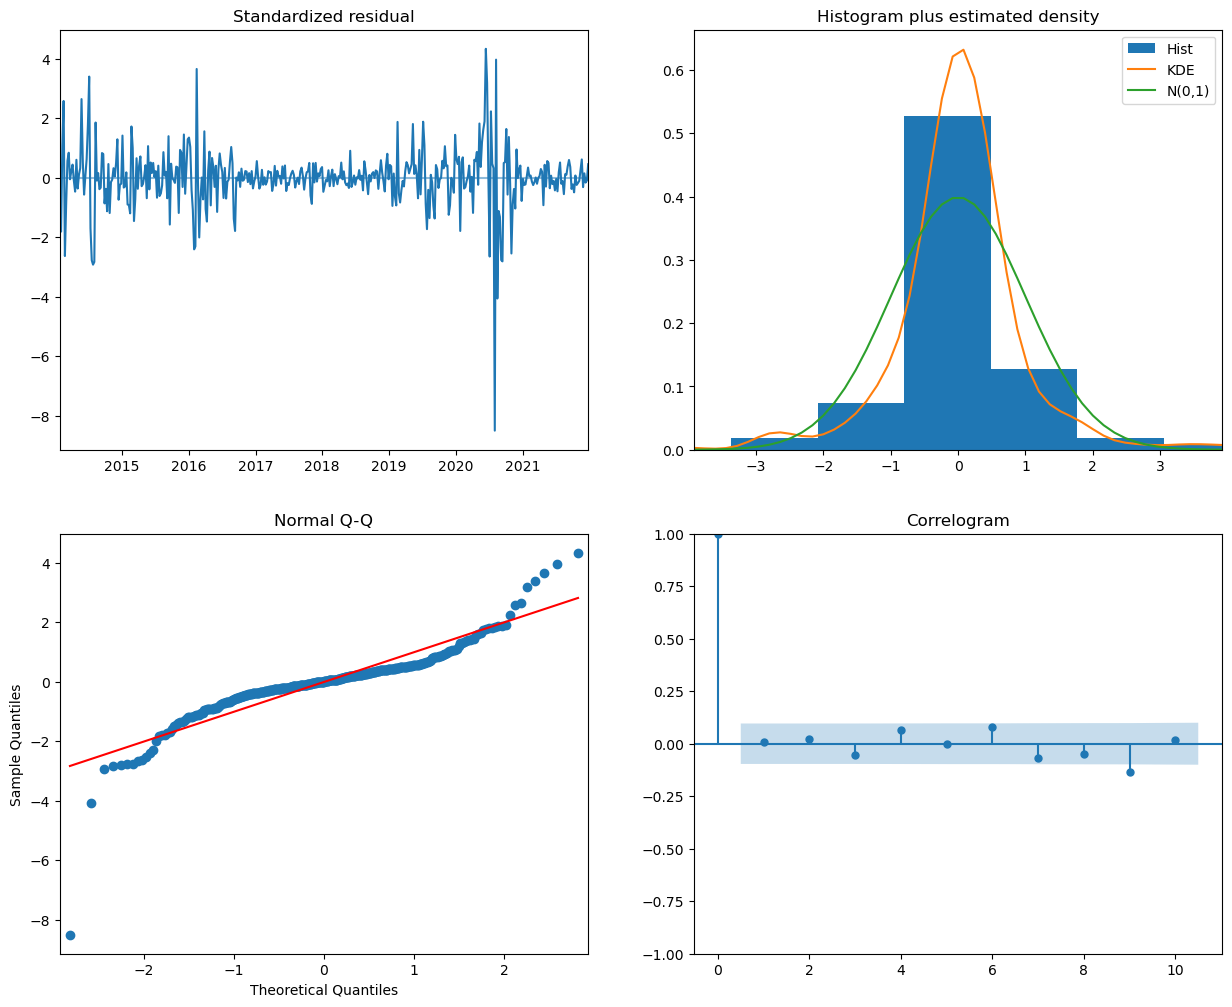

In [40]:
#Checking on the assumption of residuals of the baseline ARIMA model
arima_model_exo.plot_diagnostics(figsize=(15,12))
plt.show()

**Conclusion:**
- There are variance on the residuals of the model predictions, especially during the late 2020 period again where there are outliers.
- The histogram and Q-Q plot illustrates that the residuals are close to being normally distributed.
- Most points of the correlation plot of the residuals are within the 95% interval which indicates that the model is relatively able to capture the information in the data.
- Thus this model have satisfied most of the assumptions taken for it to be reliable.

#### Metric performance

In [41]:
#Summary of the SARIMAX model
arima_model_exo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  415
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2238.906
Date:                Sun, 11 Jun 2023   AIC                           4501.812
Time:                        16:47:40   BIC                           4550.123
Sample:                    01-19-2014   HQIC                          4520.918
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                 4.8324      6.896      0.701      0.483      -8.684      18.348
humidity            -5.4905      7.108     -0.772      0.440     -19.422       8.441
precip               0.8547      4.444      0.192      0.847      -7.856       9.566
precipcover          2.3378      5.759      0.406      0.685      -8.950      13.625
windspeed           -2.8975      4.126     -0.702      0.483     -10.985       5.190
winddir              1.9593      5.004      0.392      0.695      -7.849      11.768
sealevelpressure     3.6604      3.256      1.124      0.261      -2.721      10.041
solarenergy         -1.4689      3.756     -0.391      0.696      -8.831       5.893
ar.L1                0.7362      0.044     16.873      0.000       0.651       0.822
ma.L1               -0.8084      0.044    -18.487      0.000      -0.894      -0.723
ma.L2                0.3243      0.026     12.579      0.000       0.274       0.375
sigma2            2902.9741     93.224     31.140      0.000    2720.258    3085.690
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3887.54
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -1.28
Prob(H) (two-sided):                  0.05   Kurtosis:                        17.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

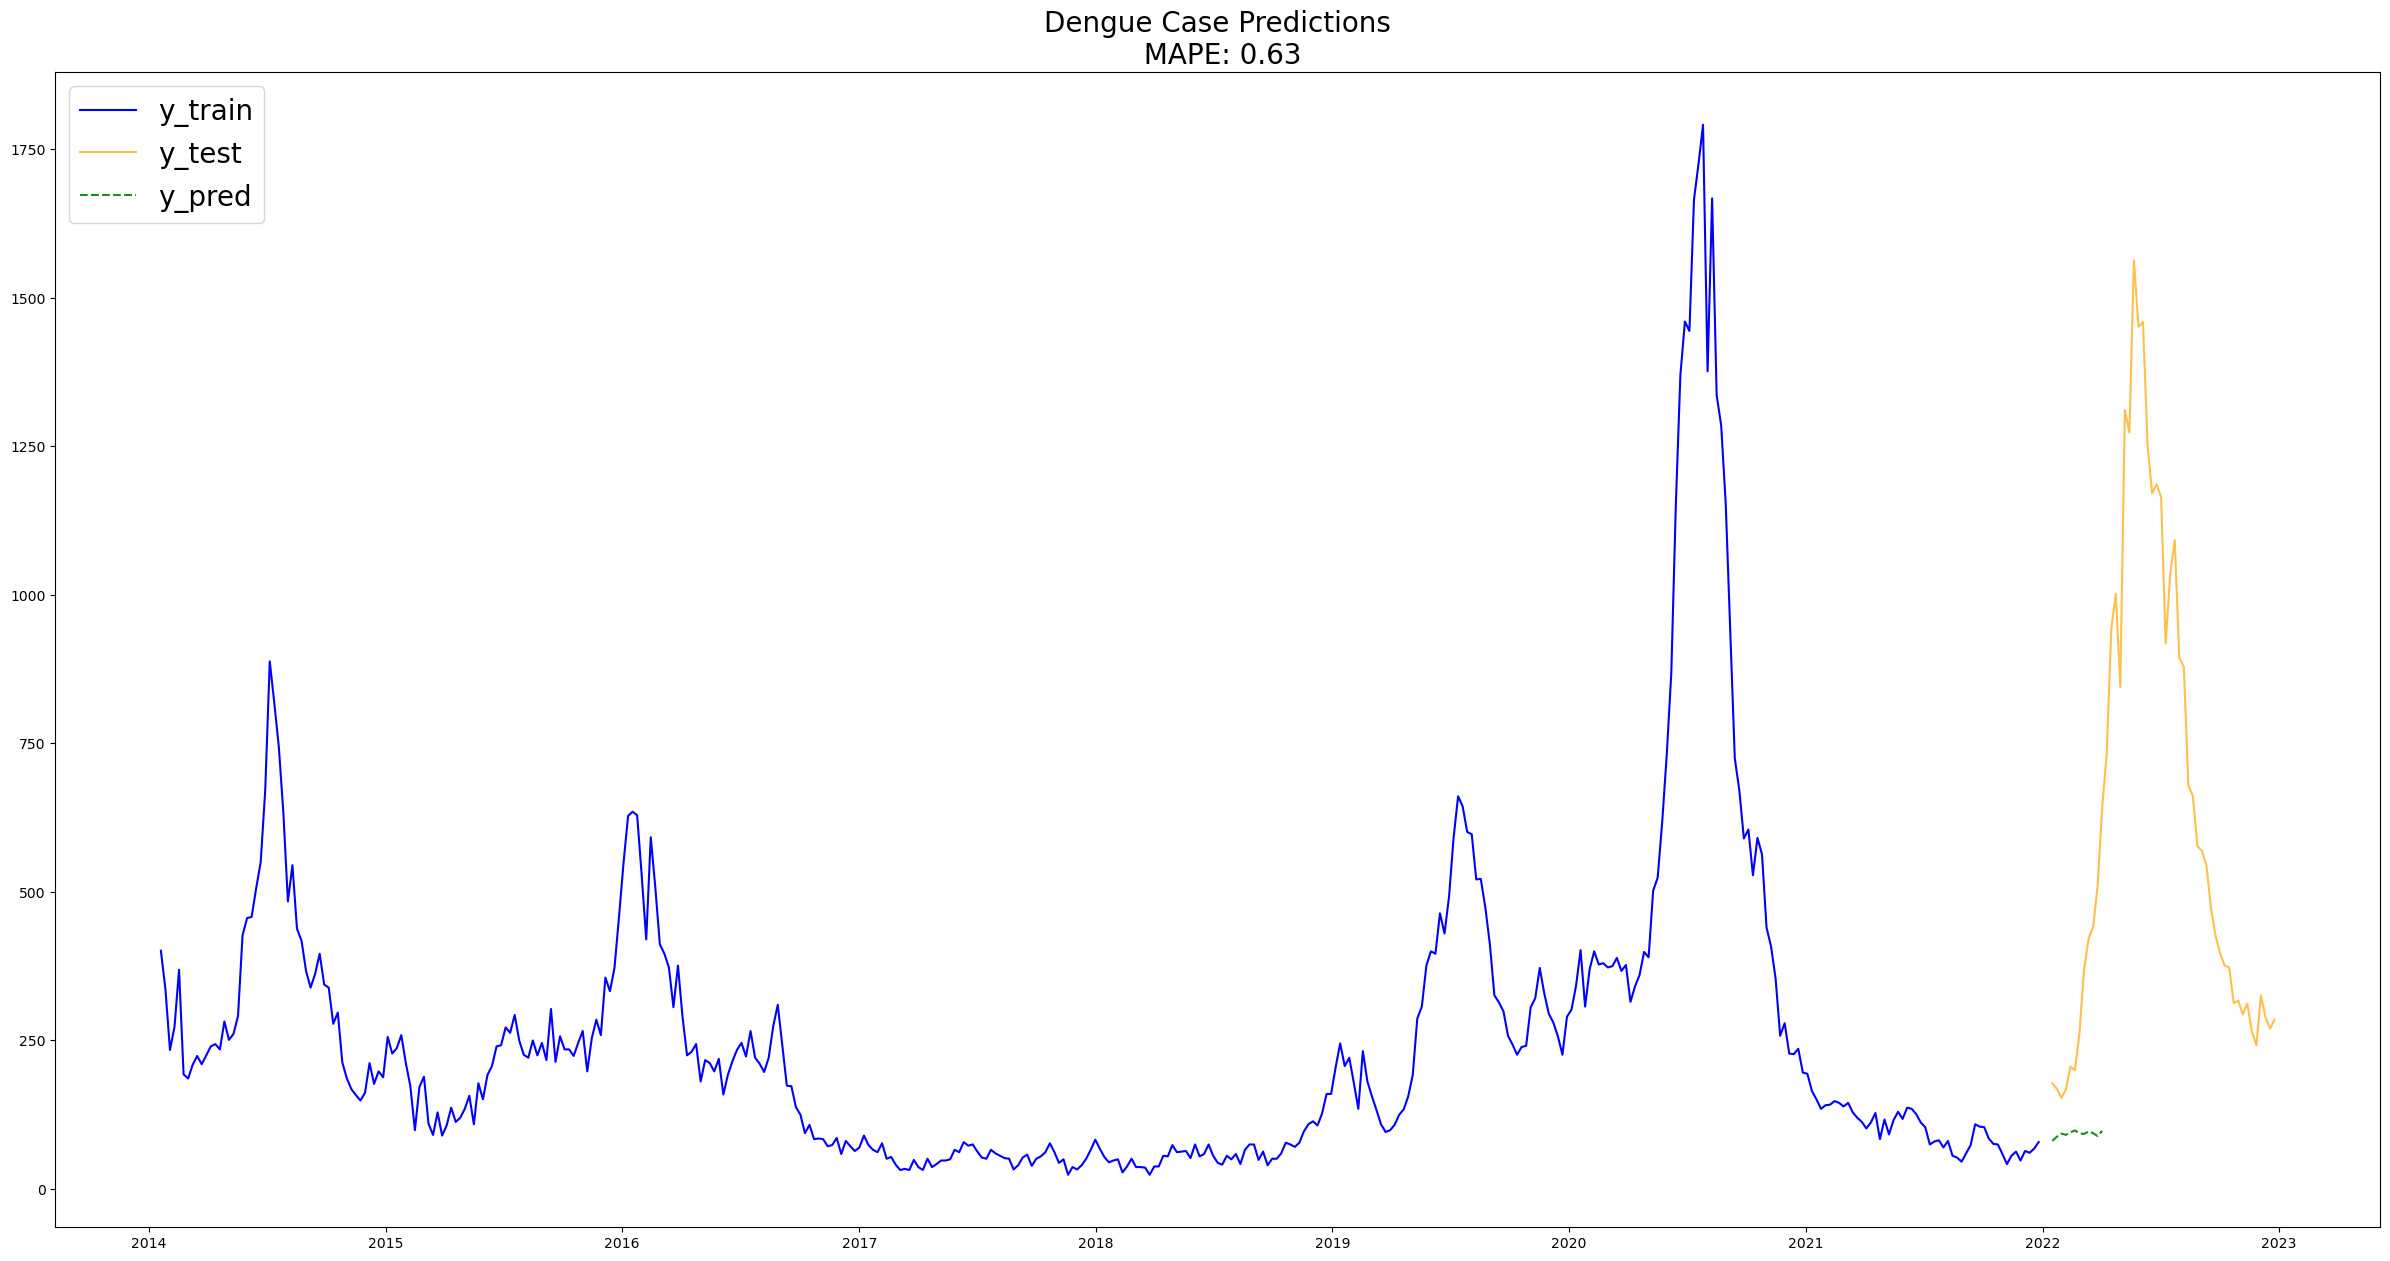

In [42]:
#Plot of forecast with metric
plot_forecast_period(y_train_SARIMAX, y_test_SARIMAX, arima_model_exo,12, X_test_scaled)

**Conclusion:**
- The MAPE metric is 0.63 which is worse than the ARIMA model previously.
    - This is possibly due to the weather features are not individually significant or created more noise for the model to learn.
        - Based on EDA, there was relatively close to no correlation between weather features and the number of dengue cases.
        - The summary from the SARIMAX model display that the weather features have no significance in explaining the trend of dengue cases (i.e All p-values are >0.05)
     - Besides possible problem with data, it could also be that the ARIMA and SARIMAX model on its own have no inbuilt optimisation to deal with hyperparameter tuning using a validation set but instead uses only the train and test set determined by the user which could lead to less optimal results as well as under/overfitting of models.
          
- Other approaches are explored, specifically with the use of [Pycaret's time series forecasting](https://pycaret.readthedocs.io/en/latest/api/time_series.html), which provides a cross validation across multiple folds to reduce the highlighted potential issue faced (i.e Optimal hyperparameter tuning and less likelihood of under/overfitting).

# Approach 3: Pycaret's SARIMA

- Using SARIMA and with the addition of cross-validation to train the SARIMA model over different parts of the train data to reduce biasness based on 1 set of training data as done perviously. Since the number of dengue cases have much fluctations and outliers, this will likely improve the model training and thus its prediction capability.
- There is also the option to determine the method of fold during the CV process which in this case it will be the use of 'sliding' which folds the model in a way that the abnormal periods of data are used more often in the training process to provide better generalisation. A visul of the portion of training data use for validation can be seen [here](#CV-split).

In [26]:
#Assigning data 
y=dengue_df['No. case'].loc['2014':'2022']

#Setting up model with CV = 10, prediction period of 12 weeks
exp = TSForecastingExperiment()
exp.setup(data=y, fh=12, fold=10, fold_strategy='sliding')

In [27]:
#Plot of the data used for train and test
exp.plot_model(plot="train_test_split")

## CV split

In [28]:
exp.plot_model(plot="cv")

## Modeling

In [29]:
#Selecting the choice of model, ARIMA, with the display of each CV folds metric
model = exp.create_model('arima')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Evaluation

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  457
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 2)   Log Likelihood               -2588.705
Date:                           Fri, 19 May 2023   AIC                           5183.411
Time:                                   02:32:26   BIC                           5195.772
Sample:                               01-05-2014   HQIC                          5188.281
                                    - 10-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2006      3.486     -0.058      0.954      -7.034       6.633
ar.L1          0.6557      0.021     31.109      0.000       0.614       0.697
sigma2      5110.6801    155.797     32.804      0.000    4805.324    5416.036
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):              1208.91
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
#Score of the model use in prediction against the test data(holdout set)
exp.predict_model(model)

#Plotting the forecast
exp.plot_model(model)

**Conclusion:**
- The MAPE metric is 0.15 which is within the acceptable range of 0.285.
    - The hyperparameter tuning with cross-validation of 10 folds have improved the ARIMA model possibly due to how the model have trained multiple times on the data.
    
- Despite an acceptable metric for the forecast period of 12 weeks, it is observed that the prediction interval diverges widely over this period implying that the model might have issues when forecasting into periods where shock is present.
- Nonetheless, it will be experimented with the use of Pycaret's SARIMAX on the weather features to see if hypertuning and cross validation will improve the model performance.

# Approach 4: Exogeneous Pycaret

- Use of Pycaret's SARIMAX modeling with weather features
- Weather features are lagged by 2 weeks and goes through RobustScaler to deal with feature outliers identified in EDA.

In [32]:
#Lagging of weather feature before setting up of Pycaret's SARIMAX
py_df=dengue_df[dengue_df.columns[1:]].shift(2)
py_df=pd.concat([dengue_df['No. case'], py_df], axis =1)
py_df.dropna(inplace=True)

In [33]:
#Setting up of model with CV=10, prediction period of 12 weeks and the exogeneous features being scaled using RobustScaler
y_exo=py_df.loc['2014':'2022']

exp_exo = TSForecastingExperiment()

exp_exo.setup(data=y_exo, target='No. case', scale_exogenous='robust', fh=12, fold=10, enforce_exogenous=True)

In [34]:
exp_exo.plot_model(plot="train_test_split")

## CV split

In [35]:
exp.plot_model(plot="cv")

## Modeling

In [36]:
model_exo = exp_exo.create_model('arima')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Evaluation

In [37]:
exp_exo.predict_model(model_exo)
exp_exo.plot_model(model_exo)

In [38]:
#Summay of Pycaret's SARIMAX model
model_exo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  455
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 2)   Log Likelihood               -2573.581
Date:                           Fri, 19 May 2023   AIC                           5169.163
Time:                                   02:32:45   BIC                           5214.437
Sample:                               01-19-2014   HQIC                          5187.002
                                    - 10-02-2022                                         
Covariance Type:                             opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.3537      3.488     -0.101      0.919      -7.191       6.484
temp                 3.3451      9.182      0.364      0.716     -14.652      21.342
humidity            -8.4661      8.331     -1.016      0.310     -24.795       7.862
precip              -0.7518      4.120     -0.182      0.855      -8.827       7.323
precipcover          7.5093      6.171      1.217      0.224      -4.585      19.604
windspeed           -3.3416      4.288     -0.779      0.436     -11.745       5.062
winddir             -2.7520      9.155     -0.301      0.764     -20.696      15.192
sealevelpressure     6.3578      4.232      1.502      0.133      -1.937      14.653
solarenergy          1.4327      5.182      0.276      0.782      -8.723      11.589
ar.L1                0.6640      0.023     29.200      0.000       0.619       0.709
sigma2            5028.6044    186.781     26.922      0.000    4662.520    5394.688
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              1080.85
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Conclusion:**
- The MAPE metric is 0.13 which is an improvement from 0.15(Approach 3).
    - The exogeneous features are not significant (at 95% confidence) individually, however there is still an improvement to the MAPE metric, this could be due to the features are correlated and have collective indirect influence on the predictions.

# Future works/Conclusion

# Summary of model performance

|Approach|Description|Performance|Conclusion|
|--|--|--|--|
|1|Baseline ARIMA model <ul><li>Autoregressive order (p) = 2</li><li>Difference order (d) = 0</li><li>Moving average order (q) = 2</li>|<ul><li>MAPE: 0.31</li></ul>|Performance did not satisfy objective (< 0.269)|
|2|SARIMAX model <ul><li>StandardScaling of exogeneous features</li><li>Autoregressive order (p) = 1</li><li>Difference order (d) = 1</li><li>Moving average order (q) = 2</li>|<ul><li>MAPE: 0.63</li></ul>|Performance did not satisfy objective (< 0.269)|
|3|Pycaret SARIMA model <ul><li>Autoregressive order (p) = 1</li><li>Difference order (d) = 0</li><li>Moving average order (q) = 0</li><li>Seasonal autoregressive order (P) = 0</li><li>Seasonal difference order (D) = 0</li><li>Seasonal moving average order (Q) = 0</li><li>Length of seasons = 2</li>|<ul><li>MAPE: 0.15</li></ul>|2nd best model, metric satisfy minimum objective (< 0.269)|
|4|Pycaret SARIMAX model <ul><li>RobustScaling of exogeneous features</li><li>Autoregressive order (p) = 1</li><li>Difference order (d) = 0</li><li>Moving average order (q) = 0</li><li>Seasonal autoregressive order (P) = 0</li><li>Seasonal difference order (D) = 0</li><li>Seasonal moving average order (Q) = 0</li><li>Length of seasons = 2</li>|<ul><li>MAPE: 0.13</li></ul>|Best model, metric satisfy minimum objective (< 0.269)|

The SARIMAX model that trains over 10 folds of data have resulted in the best metric, despite so, the weather features have shown to have no individual significance (at 95% confidence) in explaining the model. Further readings have contributed population density, type of housing and government policies as potential influential factors on the number of dengue cases which might explain why weather factors despite being important, is not as impactful.

Additionally, the weather data collected (across Singapore weather stations) reflects the macroclimate conditions which might differ to the microclimate conditions for aedes mosquito to grow. 

With the SARIMAX model trained using Pycaret library, the net amount of cost averted (assume efficacy at 80%) would expected to be `((1-0.13) x $55.93)- 40.86 = US$7.8 million` on top of Project Wolbachia operation cost reduction by 80%.

There would also be positive spill-over effects from Project Wolbachia as the released mosquitos will also reduce other mosquito trasmitted diseases such as Yellow fever, Zika and chikungunya fever, underestimating the averted economic cost.

In the calculations, there is also underestimation on Project Wolbachia cost of US$22.7 million. Since accurate predictions imply more preparation and planning of resources can be carry out thus reducing the cost further which our calculations have assumed to have not changed. 

The model have been predicted mostly on periods without shocks thus the degree of performance loss have yet to be evaluated. Based on the history of dengue cases from the EDA, there have been frequent shocks and outliers which questions the reliability of the model predictions.

The weather features used for training are currently lagged by 2 weeks. Since the targeted prediction is in 12 weeks (i.e 3 months), it implies there is a need to use 10 weeks for forecasted weather data for predictions. Therefore the prediciting capability of the model is dependent also on the accuracy of the 10-day weather forecast.

# Future works

- One of the main concern is the ability for the model to be able to predict reliably during periods of shock. Thus, it is needed to regularly train the model with recent data so the early information of shocks is learned by the model which might be able to predict an upcoming shock.

- The SARIMAX model is a form of linear model which might not be able to capture non-linear -relations/information accurately such as information of exogeneous factors (eg. temperature) where the rate/amount of Aedes mosquito growth will not be constant at different margins of temperature.

- Explore other factors such as population growth/density to be use for training of the prediction model.

- Analyse cases that include DHF cases as their economic cost differs from the regular dengue fever.